# Series de Tiempo

Esta técinica de modelado buscará predecir una variable continua h_tfa_total basada en el tiempo.

## Contexto
Despues de aplicar técias de Data Governace en etapas anteriores del proyecto, nos encontramos con una tabla de reservaciones estructurada de la siguiente manera

In [1]:
import pandas as pd

rsv = pd.read_csv('/Users/manuelrodriguez/Documents/Proyectos/ML_Models/Data/rsv_limpio.csv')
rsv.info

<bound method DataFrame.info of       ID_Reserva   Fecha_hoy                      h_res_fec h_res_fec_ok  \
0             11  2019-11-01  1970-01-01 00:00:00.020191101   2019-11-01   
1             15  2019-04-27  1970-01-01 00:00:00.020190427   2019-04-27   
2             32  2019-11-14  1970-01-01 00:00:00.020191114   2019-11-14   
3             57  2019-04-29  1970-01-01 00:00:00.020190429   2019-04-29   
4             76  2019-12-18  1970-01-01 00:00:00.020191218   2019-12-18   
...          ...         ...                            ...          ...   
5570      101971  2020-04-23  1970-01-01 00:00:00.020200423   2020-04-23   
5571      101972  2020-04-23  1970-01-01 00:00:00.020200423   2020-04-23   
5572      102052  2020-04-25  1970-01-01 00:00:00.020200425   2020-04-25   
5573      102054  2020-04-17  1970-01-01 00:00:00.020200417   2020-04-17   
5574      102156  2020-04-07  1970-01-01 00:00:00.020200407   2020-04-07   

     h_res_fec_okt  h_num_per  h_num_adu  h_num_men  h_

A pesar de esto, pasaremos el dataframe a través de un preprocesamiento enfocado a series de tiempo

In [2]:
import pandas as pd 

rsv['h_res_fec_okt'] = pd.to_datetime(rsv['h_res_fec_okt'])
rsv = rsv.sort_values('h_res_fec_okt')
rsv = rsv.set_index('h_res_fec_okt')
rsv = rsv.resample('D').sum() 
rsv = rsv[['h_tfa_total']].fillna(0)

## Visualización de nuestra serie de tiempo

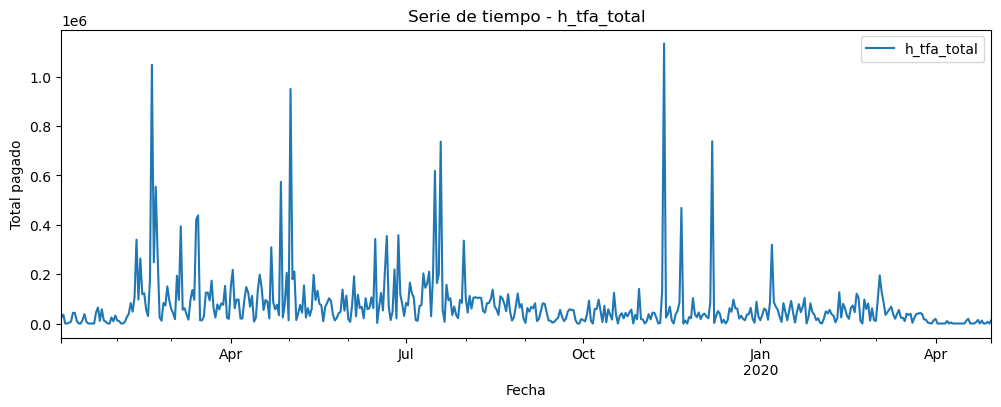

In [3]:
import matplotlib.pyplot as plt

rsv.plot(title="Serie de tiempo - h_tfa_total", figsize=(12, 4))
plt.xlabel("Fecha")
plt.ylabel("Total pagado")
plt.show()

## Evaluación
Crearemos una función para evaluar nuestros modelos

In [4]:
from sklearn.metrics import mean_squared_error

def evaluate_model(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Calcula el RMSE (raíz del MSE)
    return rmse


## División entre train y test

In [5]:
split = int(len(rsv) * 0.8)
train, test = rsv[:split], rsv[split:]

## Uso de modelos clásicos

Por si solos, modelos como SVR o RandomForest no tienen temporalidad, pero si creamos lag features que simulen una especie de memoria, podemos crear una especie de regresión supervisada que puede arrojar resultados interesantes para nuestro proyecto

In [6]:
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

def create_features(series, window=7):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)


window = 7  # 7 dias = 1 semana
X_train, y_train = create_features(train['h_tfa_total'].values, window)
X_test, y_test = create_features(
    np.concatenate([train['h_tfa_total'].values[-window:], test['h_tfa_total'].values]), window)

tscv = TimeSeriesSplit(n_splits=5)

### SVR

In [7]:
from sklearn.svm import SVR

param_grid_svr = {
    "C": [1],
    "gamma": ["scale"],
    "kernel": ["rbf"]
}

#### Busquéda de los mejores hiperparámetros

In [8]:
grid_svr = GridSearchCV(
    SVR(), param_grid_svr,
    cv=tscv,
    scoring="neg_root_mean_squared_error"
)
grid_svr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [1], 'gamma': ['scale'], 'kernel': ['rbf']},
             scoring='neg_root_mean_squared_error')

In [9]:
pred_svr = grid_svr.predict(X_test)
rmse_svr = evaluate_model(y_test, pred_svr)
print(f"RMSE SVR: {rmse_svr}")

RMSE SVR: 42855.978030558275


### Random Forest

#### Búsqueda de los mejores hiperparámetros 

In [10]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(), param_grid_rf,
    cv=tscv,
    scoring="neg_root_mean_squared_error"
)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10], 'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [11]:
pred_rf = grid_rf.predict(X_test)
rmse_rf = evaluate_model(y_test, pred_rf)
print(f"RMSE Random Forest: {rmse_rf}")

RMSE Random Forest: 52560.18303855335


## SARIMA

### Búsqueda de hiperparámetros
La biblioteca pmdarima nos ayudará a buscar automáticamente los mejores hiperparámetros para series de tiempo SARIMA 

In [12]:
import pmdarima as pm

model_sarima = pm.auto_arima(
    train,
    seasonal=True,
    m=7,  # semanal
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

model_sarima.fit(train)

pred_sarima = model_sarima.predict(n_periods=len(test))
rmse_sarima = evaluate_model(test.values, pred_sarima)
print(f"RMSE SARIMA: {rmse_sarima}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=10190.632, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10390.385, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10293.886, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10190.873, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10388.387, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=10189.059, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=10187.335, Time=0.14 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=10189.084, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=10186.379, Time=0.10 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=10188.250, Time=0.18 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=10188.240, Time=0.22 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=10189.915, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=10185.867, Time=0.03 sec
 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=10187.445, Time=0.05 sec
 ARIMA(0,1,2)(0,0,1

## XGBoost

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

def create_lag_features(series, lags=7):
    df_lag = pd.DataFrame()
    for i in range(1, lags + 1):
        df_lag[f"lag_{i}"] = series.shift(i)
    df_lag["y"] = series.values
    df_lag.dropna(inplace=True)
    return df_lag

df_lag = create_lag_features(rsv["h_tfa_total"])
X = df_lag.drop("y", axis=1)
y = df_lag["y"]

X_train_lag = X.iloc[:-len(y_test)]
y_train_lag = y.iloc[:-len(y_test)]
X_test_lag = X.iloc[-len(y_test):]


### Búsqueda de hiperparámetros

In [14]:
param_grid_xgb = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "learning_rate": [0.1, 0.01]
}

grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb,
                        cv=tscv,
                        scoring="neg_root_mean_squared_error",
                        n_jobs=-1, verbose=2)

grid_xgb.fit(X_train_lag, y_train_lag)
print("Mejores parámetros XGBoost:", grid_xgb.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=5, n_es

In [15]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=5,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Evaluación

In [16]:
y_pred_xgboost = xgb_model.predict(X_test)
rmse_xgboost = evaluate_model(y_test, y_pred_xgboost)

print(f"RMSE XGBoost: {rmse_xgboost}")


RMSE XGBoost: 67954.12049242591


## Comparación de Resultados 

Comparación de RMSE:
SVR: 42855.98
Random Forest: 52560.18
SARIMA: 46255.04
XGBoost: 67954.12


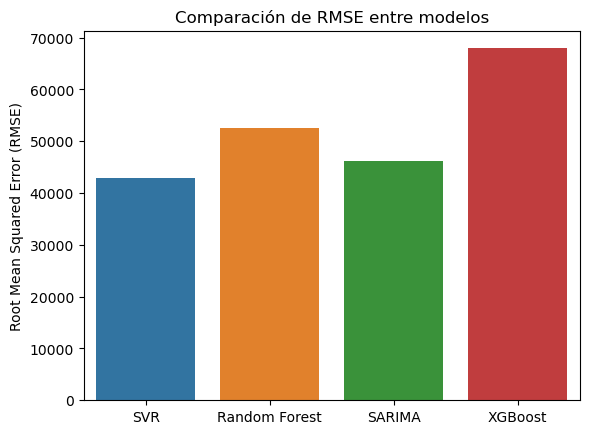

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

results = {
    "SVR": rmse_svr,
    "Random Forest": rmse_rf,
    "SARIMA": rmse_sarima,
    "XGBoost": rmse_xgboost
}

print("Comparación de RMSE:")
for model, rmse in results.items():
    print(f"{model}: {rmse:.2f}")

sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Comparación de RMSE entre modelos")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.show()